In [122]:
import matlab
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
import warnings
warnings.filterwarnings('ignore')

In [123]:
eng = matlab.engine.start_matlab()

In [12]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[1572-1][0])
month = np.int16(quietDays[1572-1][1])
day = np.int16(quietDays[1572-1][2])
# year = 2010
# month = 9
# day = 6
hour = 0
minute = 0
second = 0
numberOfDaysWithData = 2


startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, hour, minute, second)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

# mat = loadmat("../../../../opt/dir.indices/station.mat")
mat = loadmat("D:/IRAP/dir.indices/station.mat")
allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [61]:
stationIndicatorRatioVariation = defaultdict(list)
numberOfMinutesNeededInTheTimeStamp=0
timeBetweenValues=0
numberOfValues=0
dataResolution=0
latMin=40
latMax=60

In [14]:
indicatorVariationArray = np.array([])
localIndicatorVariationArray = np.array([])
indicatorVariationArrayLocalTime = np.array([])
localNormalized01StationIndicatorVariation = np.array([])
stationsPerLat = defaultdict(list)

In [15]:
normalizedStationIndicatorVariation = defaultdict(list)
normalized01StationIndicatorVariation = defaultdict(list)
maxValueinDataset=0
minValueinDataset=0

In [16]:
ReconstructedArray = np.array([])

In [143]:
trainingDatasetPathWindows = "D:/IRAP/Training_Dataset"

In [150]:
def GenerateTrainingSet():
    global year
    global month
    global day
    global startDate
    global endDate
    global startDateMatlab
    global endDateMatlab
    global stationsWithNoData
    global stationsNonexistentInFolder
    global stationsOut
    global dotsX
    global dotsY
    global dotsHeights
    global indicatorVariationArrayLocalTime
    
    stationsWithNoData = []
    stationsNonexistentInFolder = []
    stationsOut = dict()
    dotsX=[]
    dotsY=[]
    dotsHeights=[]
    stationIndicatorVariation = defaultdict(list)
    index=0
    for i in range(1500, 1700, numberOfDaysWithData):
        year = np.int16(quietDays[i][0])
        month = np.int16(quietDays[i][1])
        day = np.int16(quietDays[i][2])
        
        startDate = datetime.datetime(year, month, day, hour, minute, second)
        endDate = startDate+datetime.timedelta(days=numberOfDaysWithData)
        
        startDateMatlab = [year, month, day, hour, minute, second]
        endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]
        
        RequestMatlab()
        print("Request Matlab done")
        MakeStationIndicatorVariation()
        ManuallyNormalizeData01()      
        makeIndicatorVariationArray(False,True)
        ResizeForPlot()
        print("Make arrays, normalize and calculate local time done")
        ReconstructedArray = PredictIndicatorForAllLatitudes(indicatorVariationArrayLocalTime)
        np.save("{}/x_train/indicatorVariationArrayLocalTime{}".format(trainingDatasetPathWindows,index), ReconstructedArray)
        print("Reconstruct array and save label done")
        ArrayWithGaps=RemoveData(ReconstructedArray)
        np.save("{}/x_train_lines/indicatorVariationArrayLocalTime{}".format(trainingDatasetPathWindows,index), ArrayWithGaps)
        print("Make gaps and save feature done")
        index+=1
        print("Matrix saved for date: {}".format(startDate))
        clear_output(wait=True)
    
GenerateTrainingSet()       

Request Matlab done
Make arrays, normalize and calculate local time done
Reconstruct array and save label done
Make gaps and save feature done
Matrix saved for date: 2010-02-21 00:00:00


In [17]:
def RemoveData(array):
    fromLat=46
    toLat=50
    target=np.full((toLat-fromLat, array.shape[1]), np.nan)
    c=0
    for i in range(fromLat,toLat):
        target[c]=array[i-latMin]
        array[i-latMin]=np.full(array.shape[1],np.nan)
        c+=1
    return array

In [125]:
def RequestMatlab():
    for st in allStationCodes: 
        try:
            stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
            stLongeo=np.float32(stationsOut[st].get("longeo"))
            stLatgeo=np.float32(stationsOut[st].get("latgeo"))
            stAlt=np.float32(stationsOut[st].get("alt"))
            igrf = eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([startDateMatlab]), nargout=4)
            stationsOut[st]["igrf"] = igrf[3]
        except:
            stationsNonexistentInFolder.append(st)

In [19]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

Wall time: 30.7 ms


In [96]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
#     y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
#     z=np.float32(dataSt.get("z")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
#     z2=np.float32(dataSt.get("z2")[timeshift])
    igrf=np.float32(dataSt.get("igrf"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    ratio = ((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/igrf)
#     weight = gaussian(ratio, 1, 0)
    return np.round(x2,10), ratio

In [91]:
def MakeStationIndicatorVariation():
    
    global stationIndicatorVariation
    global stationIndicatorRatioVariation
    global stationIndicatorVariation
    global numberOfMinutesNeededInTheTimeStamp
    global timeBetweenValues
    global numberOfValues
    global dataResolution
    global latMin
    global latMax
    
    stationIndicatorRatioVariation = defaultdict(list)
    stationIndicatorVariation.clear()
    numberOfMinutesNeededInTheTimeStamp = 1440*numberOfDaysWithData
    timeBetweenValues = 10
    numberOfValues = np.int16(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)
    dataResolution = 0

    if float(360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)).is_integer():
        dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)

        for st in allStationCodes:
            if stationsOut[st]:
                if stationsOut[st].get("latgeo") > latMin and stationsOut[st].get("latgeo") < latMax:
            #         st="mcq"
                    delta = endDate-startDate
                    totalMinutes = (delta.total_seconds()+1)/60
                    for i in range(0, np.int16(totalMinutes), timeBetweenValues):
#                         try:
                        update = datetime.timedelta(minutes=i)
                        currentDate = startDate+update
                        magneticValue, ratio = IndicatorCalculation(stationsOut.get(st), i, currentDate)
                        stationIndicatorVariation[st].append(magneticValue)
                        stationIndicatorRatioVariation[st].append(ratio)
#                         except:
#                             None

    else:
        print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
        sys.exit

In [22]:
def normalizeWithGivenBounds(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]               

def ManuallyNormalizeData01():
    global normalizedStationIndicatorVariation
    global normalized01StationIndicatorVariation
    global maxValueinDataset
    global minValueinDataset
    normalizedStationIndicatorVariation = defaultdict(list)
    normalized01StationIndicatorVariation = defaultdict(list)
    maxValueinDataset=0
    minValueinDataset=0
    max_values = np.array([])
    min_values = np.array([])
    max_values_ratio = np.array([])
    min_values_ratio = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
                max_values_ratio = np.append(max_values_ratio, max(stationIndicatorRatioVariation[st])) 
                min_values_ratio = np.append(min_values_ratio, min(stationIndicatorRatioVariation[st])) 

    totalMax = max(max_values)
    totalMin = min(min_values)
    totalMaxRatio = max(max_values_ratio)
    totalMinRatio = min(min_values_ratio)
    maxValueinDataset = totalMax
    minValueinDataset = totalMin
    
    bounds = np.array([0,1])   
    boundsRatio = np.array([-1,1])   
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            localMax = max(stationIndicatorVariation[st])
            localMin = min(stationIndicatorVariation[st])
            localMaxRatio = max(stationIndicatorRatioVariation[st])
            localMinRatio = min(stationIndicatorRatioVariation[st])
            
#             stationIndicatorRatioVariation[st]=normalizeWithGivenBounds(np.array(stationIndicatorRatioVariation[st]), {'actual': {'lower': localMinRatio, 'upper': localMaxRatio}, 'desired': {'lower': boundsRatio[0], 'upper': boundsRatio[1]}})
            #When the ratio is far from the reference it's value tends to 0, when the ration corresponds to the reference the value tends to 1
            IndicatorVariationAppliedRatio=stationIndicatorVariation.copy()
            for i in range(0, len(stationIndicatorVariation[st])):
                IndicatorVariationAppliedRatio[st][i] = stationIndicatorVariation[st][i]*stationIndicatorRatioVariation[st][i]
            normalized01StationIndicatorVariation[st] = normalizeWithGivenBounds(np.array(IndicatorVariationAppliedRatio[st]), {'actual': {'lower': totalMin, 'upper': totalMax}, 'desired': {'lower': bounds[0], 'upper': bounds[1]}})

In [55]:
def indexValueOnLocalTime(array, st, i):
    numberOfValuesLong = array.shape[1]
    localTimeValuesArray = np.full((180, numberOfValuesLong), np.nan)
    long = float(stationsOut[st].get("longeo"))
    shiftValues = np.round((long*4)/timeBetweenValues,0)
    initialShiftValues = shiftValues
    decreasingIndex=0
    increasingIndex=0
    for y in range(np.int16(numberOfValues/numberOfDaysWithData),np.int16(numberOfValues)):
        if y+shiftValues>=array.shape[1]:
            localTimeValuesArray[i][np.int16(y-(y-shiftValues))-decreasingIndex] = array[i][np.int16(numberOfValues/numberOfDaysWithData-decreasingIndex)]
            decreasingIndex+=1
#             shiftValues-=1
        else:
            localTimeValuesArray[i][np.int16(y-y+shiftValues+increasingIndex)] = array[i][y]
            increasingIndex+=1
            
    return localTimeValuesArray[i] 

In [42]:
print(list(normalized01StationIndicatorVariation.keys())[1])

aqu


In [63]:

def makeIndicatorVariationArray(normalizedGauss, normalizedScaler):
    global indicatorVariationArray
    global localIndicatorVariationArray
    global indicatorVariationArrayLocalTime
    global localNormalized01StationIndicatorVariation
    global stationsPerLat
    
    indicatorVariationArray = np.full((180, len(normalized01StationIndicatorVariation[list(normalized01StationIndicatorVariation.keys())[1]])), np.nan)
    localIndicatorVariationArray = np.full_like(indicatorVariationArray, np.nan)
    indicatorVariationArrayLocalTime = np.full((180, len(normalized01StationIndicatorVariation[list(normalized01StationIndicatorVariation.keys())[1]])), np.nan)
    localNormalized01StationIndicatorVariation = np.full((180, len(normalized01StationIndicatorVariation[list(normalized01StationIndicatorVariation.keys())[1]])), np.nan)
    stationsPerLat = defaultdict(list)

    intermediateLocalIndicatorVariationArray = np.empty_like(localIndicatorVariationArray)
    intermediateLocalNormalized01StationIndicatorVariation = np.empty_like(localNormalized01StationIndicatorVariation)
    alreadyFilled = False
    for st in allStationCodes:
#         st='clf'
        alreadyFilled=False
        for i in range(latMin, latMax):
            if not isinstance(stationsOut[st], matlab.double):
                if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                    if stationsOut[st].get('longeo')<40:
                        stationsPerLat[i+90].append(st)
                        if len(stationsPerLat[i+90])>1:
                            alreadyFilled=True
    #                     if st=="aae": print i+90
    #                     if i+90==112: print stationsOut[st].get('longeo')
                        if normalizedScaler:
                            if normalized01StationIndicatorVariation[st]:
                                if alreadyFilled==True:
                                    intermediateLocalIndicatorVariationArray = np.array(localIndicatorVariationArray, copy=True)
                                    intermediateLocalNormalized01StationIndicatorVariation = np.array(localNormalized01StationIndicatorVariation, copy=True)

                                for t in range(np.int16(numberOfValues/numberOfDaysWithData), np.int16(numberOfValues)):
#                                     print i+90, t
                                    try:
                                        localIndicatorVariationArray[i+90][t] = normalized01StationIndicatorVariation[st][t]
                                    except:
                                        print (st)
                                try:
                                    localNormalized01StationIndicatorVariation[i+90] = normalized01StationIndicatorVariation[st]
                                except:
                                    print (st)
                                    
                                if alreadyFilled==True:
                                    for a in range(0,len(indicatorVariationArray[1])):
                                        localIndicatorVariationArray[i+90][a] = (intermediateLocalIndicatorVariationArray[i+90][a]+localIndicatorVariationArray[i+90][a])/2
                                        localNormalized01StationIndicatorVariation[i+90][a] = (intermediateLocalNormalized01StationIndicatorVariation[i+90][a]+localNormalized01StationIndicatorVariation[i+90][a])/2

                                indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(localNormalized01StationIndicatorVariation, st, i+90)
                                indicatorVariationArray[i+90] = localIndicatorVariationArray[i+90]

                        elif normalizedGauss: 
                            indicatorVariationArray[i+90]=AdaptDimensions(np.array(normalizedStationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                        else: 
                            indicatorVariationArray[i+90]=AdaptDimensions(np.array(stationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                else:
                    None

In [60]:
print(numberOfValues)

288.0


In [69]:
def ResizeForPlot():
    global indicatorVariationArrayLocalTime
    global indicatorVariationArray
    indicatorVariationArrayResized = np.empty([latMax-latMin, np.int16(numberOfValues-(numberOfValues/numberOfDaysWithData))])
    indicatorVariationArrayLocalTimeResized = np.empty([latMax-latMin, np.int16(numberOfValues-(numberOfValues/numberOfDaysWithData))])
    m=0
    for i in range(latMin+90, latMax+90):
        for y in range(np.int16(numberOfValues/numberOfDaysWithData),numberOfValues):
            indicatorVariationArrayResized[m][np.int16(y-numberOfValues/numberOfDaysWithData)]=indicatorVariationArray[i][y]
        m+=1
    indicatorVariationArray = np.empty_like(indicatorVariationArrayResized)
    indicatorVariationArray=indicatorVariationArrayResized[:]

    m=0
    for i in range(latMin+90, latMax+90):
        for y in range(0,np.int16(numberOfValues-(numberOfValues/numberOfDaysWithData))):
            indicatorVariationArrayLocalTimeResized[m][y]=indicatorVariationArrayLocalTime[i][y]
        m+=1
    indicatorVariationArrayLocalTime = np.empty_like(indicatorVariationArrayLocalTimeResized)
    indicatorVariationArrayLocalTime=indicatorVariationArrayLocalTimeResized[:]

In [149]:
def PredictIndicatorForAllLatitudes(baseArray):
    global ReconstructedArray
    predictionArray = np.empty_like(baseArray)
    
    predictionArray=np.copy(baseArray)
    
#     params = ParametersTuningPoly(predictionArray,predictionArray.shape[1]/2)
    modelTuned = ParametersTuningPoly(predictionArray,baseArray.shape[1]/2)
    for i in range(0,baseArray.shape[0]):
        specificLatitudeTimePrediction = np.full(baseArray.shape[1], np.nan)
        if math.isnan(baseArray[i][5]):
            for y in range(5,baseArray.shape[1]):  
#                 print("Latitude index {} predicted out of {} in total, value: {}".format(i+latMin, baseArray.shape[0]+latMin,y))
#                 print("Hyper parameters {}".format(modelTuned))
                specificLatitudeTimePrediction[y] = GetIndicatorLongPrediction(i,y,modelTuned,predictionArray)
            predictionArray[i] = specificLatitudeTimePrediction
    return predictionArray

In [34]:
def SaveMatrix(i):
    global indicatorVariationArrayLocalTime
    global ReconstructedArray
    np.save("../TrainingDataset/x_train_lines/indicatorVariationArrayLocalTime{}".format(i), indicatorVariationArrayLocalTime)
    np.save("../TrainingDataset/x_train/indicatorVariationArrayLocalTime{}".format(i), ReconstructedArray)

In [141]:
def GetIndicatorLongPrediction(latitude,longitude, params, baseArray):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][longitude])
    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    x,y = RemoveInfNan(x, y)
    latitude = np.array(latitude)
    return PolyRegression(x,y,params).predict(latitude.reshape(-1,1))
#     return SupportVectorRegression(x,y,params).predict(latitude)

In [29]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [140]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    model = svr_rbf.fit(latValues, indicatorValues)
    
    return model

def PolyRegression(latValues, indicatorValues, params):
#     params = {'polynomialfeatures__degree': np.array([16]), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
#     poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_grid = PolynomialRegression()
    poly_grid.set_params(**params)
    poly_grid.fit(latValues, indicatorValues)
#     print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
#     print("With {}% accuracy".format(poly_grid.best_score_))
    return poly_grid

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ParametersTuning(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.scatter(X_train, y_train)
#     ax2.scatter(X_test, y_test)
#     fig.set_size_inches(15,5)
    
    parameters = {'kernel':['rbf'], 'gamma': [1e-4, 1e-3],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test, y_test))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

def ParametersTuningPoly(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][np.int16(long)])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    
    paramsTuning = {'polynomialfeatures__degree': np.arange(2,5,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_gridTuning = GridSearchCV(PolynomialRegression(), paramsTuning, cv=10, scoring='r2', verbose=0) #Scoring with coefficient of determination r2
    poly_gridTuning.fit(x, y)
#     print("Best hyper parameters found at: {}".format(poly_gridTuning.best_params_))
#     print("With {}% accuracy".format(poly_gridTuning.best_score_))
    return poly_gridTuning.best_params_

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

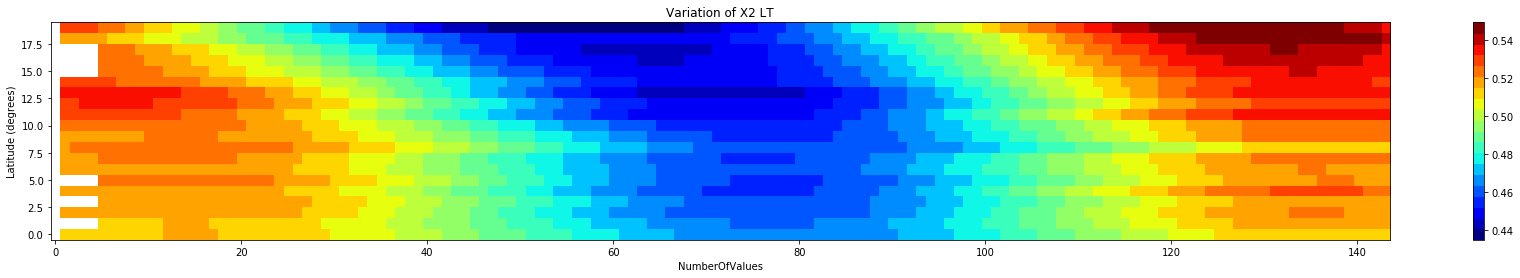

In [156]:
fig= plt.figure(figsize=(30,4))
imageIndex=2
matrixToPlot = np.load("{}/x_train/indicatorVariationArrayLocalTime{}.npy".format(trainingDatasetPathWindows,imageIndex))
# matrixToPlot = np.load("../TrainingDataset/x_train_lines/indicatorVariationArrayLocalTime{}.npy".format(imageIndex))
# print matrixToPlot
plt.imshow(matrixToPlot, origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
plt.title("Variation of X2 LT")
plt.xlabel("NumberOfValues")
plt.ylabel("Latitude (degrees)")
plt.colorbar()